# plot MI decay for birdsong

In [1]:
import pandas as pd
from parallelspaper.config.paths import DATA_DIR, FIGURE_DIR
from parallelspaper.birdsong_datasets import BCOL_DICT
import numpy as np
from parallelspaper import information_theory as it 
from parallelspaper import model_fitting as mf
from parallelspaper.utils import save_fig

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib inline

### load fit df and determine length to compute MI

In [3]:
starling_seq_df = pd.read_pickle(DATA_DIR / 'song_seq_df/starling.pickle')
CAVI_CATH_seq_df = pd.read_pickle(DATA_DIR / 'song_seq_df/CAVI_CATH.pickle')
BF_seq_df = pd.read_pickle(DATA_DIR / 'song_seq_df/BF.pickle')
seq_dfs = pd.concat([starling_seq_df, CAVI_CATH_seq_df, BF_seq_df])

In [4]:
fit_df = pd.read_pickle(DATA_DIR / 'MI_DF/birdsong/birdsong_fit_df_long.pickle')

In [5]:
song_d = {}
for species in np.unique(fit_df.species):
    print(species)
    species_fit_df = fit_df[fit_df.species == species]
    species_fit_df.R2_concat.values
    r2_100 = species_fit_df[species_fit_df.d == 100].R2_concat.values[0]
    species_d = species_fit_df.d.values[(species_fit_df.R2_concat.values > r2_100 * .999)][-1]
    song_d[species] = species_d
    

BF
CATH
CAVI
Starling


#### get MI of the longest distance within 99.9% of $r^2$ of 100 syllables distance

In [6]:
n_jobs = 20; verbosity = 0

BF


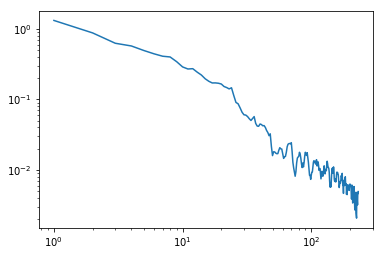

CATH


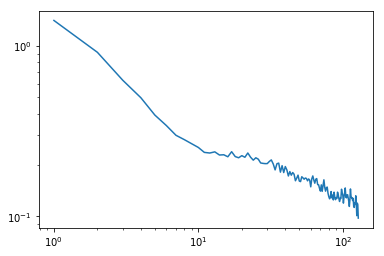

CAVI


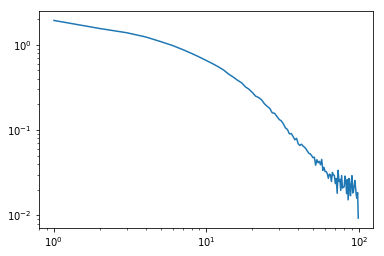

Starling


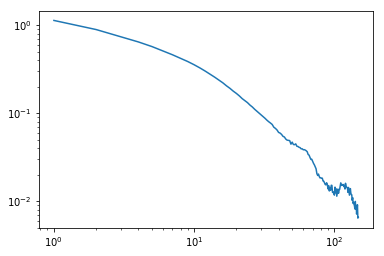

In [7]:
MI_DF = pd.DataFrame(columns=['species', 'type', 'MI', 'MI_shuff', 'distances',
                              'MI_var', 'MI_shuff_var', 'results_power', 'results_exp', 'results_pow_exp'])

for species in np.unique(seq_dfs.species):
    species_df = seq_dfs[seq_dfs.species ==
                         species].sort_values(by=['bird', 'rec_num'])
    print(species)
    # analysis by day
    day_group = []
    for bird in np.unique(species_df.bird.values):
        bird_df = species_df[species_df.bird == bird]
        for day in np.unique(bird_df.day.values):
            day_df = bird_df[bird_df.day == day]
            day_group.append(np.concatenate(day_df.syllables.values))
    units = day_group
    distances = np.arange(1, song_d[species])
    (MI, var_MI), (MI_shuff, MI_shuff_var) = it.sequential_mutual_information(
        units, distances, n_jobs=n_jobs, verbosity=verbosity)
    sig = MI-MI_shuff
    results_power, results_exp, results_pow_exp, best_fit_model = mf.fit_models(
        distances, sig)
    plt.loglog(distances, MI-MI_shuff)
    plt.show()
    MI_DF.loc[len(MI_DF)] = [species, 'session', MI, MI_shuff, distances,
                             var_MI, MI_shuff_var, results_power, results_exp, results_pow_exp]

In [8]:
subset_MI_DF = MI_DF 
subset_MI_DF['concat_results'] = subset_MI_DF.results_pow_exp

### plot main decay results for birdsong

BF 20.438935945678935
CATH 1.6265605739609303
CAVI 21.445260759716675
Starling 26.732355583482818


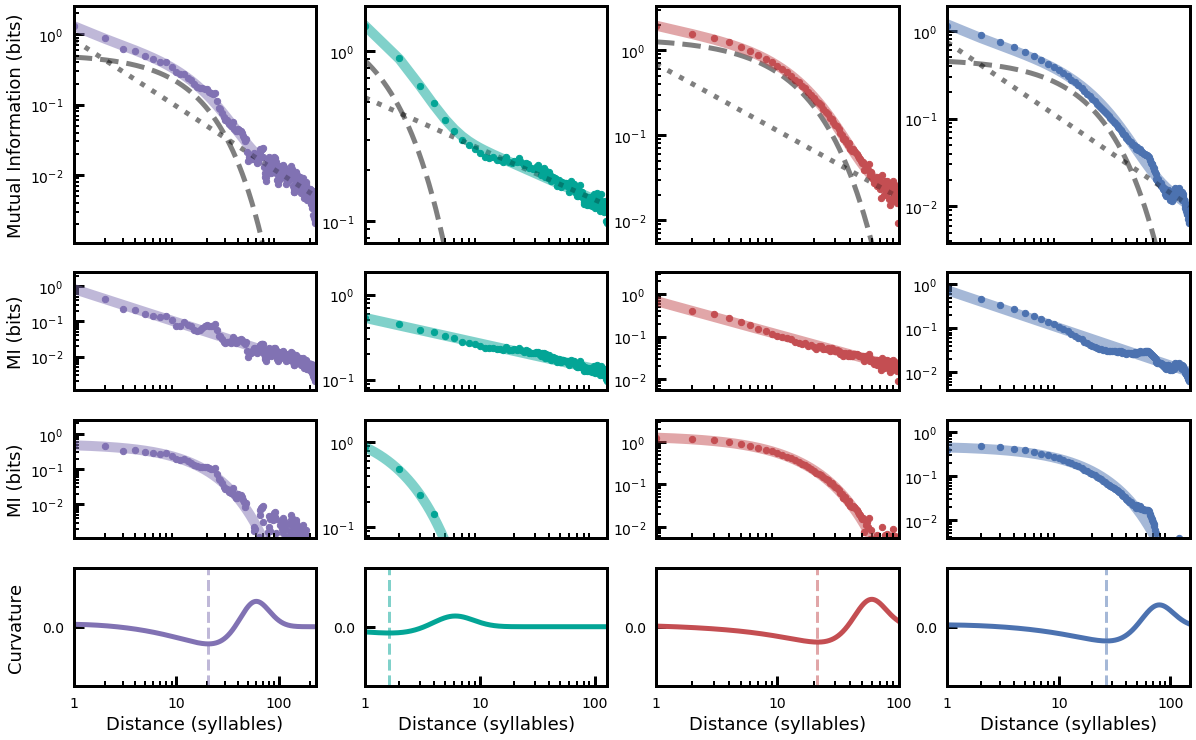

In [9]:
yoff=-.20
ncols = 4
zoom = 5
hr = [1, 0.5, 0.5, 0.5]
nrows = np.ceil(len(subset_MI_DF)/ncols).astype(int)
fig = plt.figure(figsize=(len(subset_MI_DF)*zoom,np.sum(hr)*zoom)) 
gs = gridspec.GridSpec(ncols=len(subset_MI_DF), nrows=4, height_ratios=hr) 

for axi, (idx, row) in enumerate(subset_MI_DF.sort_values(by=['type', 'species']).iterrows()):
    color = BCOL_DICT[row.species]
    ax0 = plt.subplot(gs[0,axi])
    ax = ax0
    sig = np.array(row.MI-row.MI_shuff)
    distances = row.distances
    sig = sig
    distances = distances
    # get signal limits
    sig_lims = np.log([np.min(sig[sig>0]), np.nanmax(sig)])
    sig_lims = [sig_lims[0] - (sig_lims[1]-sig_lims[0])/10,
                    sig_lims[1] + (sig_lims[1]-sig_lims[0])/10]
            
    if axi==0: 
            ax.set_ylabel('Mutual Information (bits)', labelpad=5, fontsize=18)
            ax.yaxis.set_label_coords(yoff,0.5)
            
    # model data
    #row.concat_results.params.intercept = 0
    distances_model = np.logspace(0,np.log10(distances[-1]), base=10, num=1000)
    y_model = mf.get_y(mf.pow_exp_decay, row.concat_results, distances)
    y_pow = mf.get_y(mf.powerlaw_decay, row.concat_results, distances_model)
    y_exp = mf.get_y(mf.exp_decay, row.concat_results, distances_model)
    y_pow_dat = mf.get_y(mf.powerlaw_decay, row.concat_results, distances)
    y_exp_dat = mf.get_y(mf.exp_decay, row.concat_results, distances)
    
    # plot real data
    ax.scatter(distances, sig, alpha = 1, s=40, color=color)   
    ax.plot(distances_model, y_pow, ls='dotted', color= 'k', lw=5, alpha=0.5)
    ax.plot(distances_model, y_exp-row.concat_results.params['intercept'].value, ls='dashed', color= 'k', lw=5, alpha=0.5)
    
    # plot modelled data
    ax.plot(distances, y_model, alpha = 0.5, lw=10, color=color)
    
    # plot powerlaw component
    ax1 = plt.subplot(gs[1,axi])
    ax = ax1
    ax.plot(distances_model, y_pow-row.concat_results.params['intercept'].value, alpha = 0.5, lw=10, color=color)
    ax.scatter(distances, sig-y_exp_dat, alpha = 1, s=40, color=color)   
    
    # plot exponential component
    ax2 = plt.subplot(gs[2,axi])
    ax = ax2
    ax.plot(distances_model, y_exp-row.concat_results.params['intercept'].value, alpha = 0.5, lw=10, color=color)
    ax.scatter(distances, sig-y_pow_dat, alpha = 1, s=40, color=color)   
    
    # plot curvature
    ax3 = plt.subplot(gs[3,axi])
    ax = ax3
    if axi==0: 
        ax.set_ylabel('Curvature', labelpad=5, fontsize=18)
        ax.yaxis.set_label_coords(yoff,0.5)
        ax.set_yticks([0.0])
        ax.set_yticklabels(['0.0'])
    else:
        ax.set_yticks([0.0])
        ax.set_yticklabels(['0.0'])
    
    
    # curvature 
    distances = np.logspace(0,np.log10(song_d[row.species]), base=10, num=1000)
    y_model = mf.get_y(mf.pow_exp_decay, row.concat_results, distances)
    # get curvature of model_y
    curvature_model = mf.curvature(np.log(y_model))
    peaks = np.where((
            (curvature_model[:-1] < curvature_model[1:])[1:] & (curvature_model[1:] < curvature_model[:-1])[:-1]
        ))
    min_peak = peaks[0][0]
    ax.plot(distances[5:-5], curvature_model[5:-5], alpha = 1, lw=5, color=color)
    ax.set_ylim([-1e-4,1e-4])
    
    peak_of_interest = int(min_peak)
    ax.axvline(distances[peak_of_interest], lw=3,alpha=0.5, color=color, ls='dashed')
    ax.set_xlabel('Distance (syllables)', labelpad=5, fontsize=18)
    print(row.species, distances[peak_of_interest])
    
    
    # axis labelling, etc
    ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
    ax.tick_params(which='major', length=10, width =3)
    ax.tick_params(which='minor', length=5, width =2)
    ax.set_xscale( "log" , basex=10)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
        ax.spines[axis].set_color('k')
    ax.set_xlim([1,song_d[row.species]])
    
    # set axis limits, etc
    for ax in [ax1, ax2]:
        if axi==0: 
            ax.set_ylabel('MI (bits)', labelpad=5, fontsize=18)
            ax.yaxis.set_label_coords(yoff,0.5)
    
    for ax in [ax0,ax1,ax2]:
        ax.set_xlim([distances[0], distances[-1]])
        ax.set_ylim(np.exp(sig_lims))
        ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
        ax.tick_params(which='major', length=10, width =3)
        ax.tick_params(which='minor', length=5, width =2)
        ax.set_xscale( "log" , basex=10)
        ax.set_yscale( "log" , basey=10)
        ax.set_xticks([])
        ax.set_ylim(np.exp(sig_lims))
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(3)
            ax.spines[axis].set_color('k')
    ax3.set_xticks([1,10,100])
    ax3.set_xticklabels(['1','10','100'])
        

save_fig(FIGURE_DIR/'song_fig')

### Dataset statistics

In [10]:
CAVICATH_stats_df = pd.read_pickle(DATA_DIR / 'stats_df/CAVICATH_stats_df.pickle')
Starling_stats_df = pd.read_pickle(DATA_DIR / 'stats_df/starling_stats_df.pickle')
BF_stats_df = pd.read_pickle(DATA_DIR / 'stats_df/BF_stats_df.pickle')

In [11]:
stats_df = pd.concat([CAVICATH_stats_df, Starling_stats_df, BF_stats_df])

In [12]:
stats_df

,species,unique_birds,num_birds,num_syllables_per_bird,num_syllables_total,num_recordings,recording_duration_syllable,unique_syllables_per_bird,unique_syllables_total,recordings_length_total,recordings_lengths,syllable_duration_s,isi
0,CAVI,"[?, AGBk, AGO, AOBu, AYO, BuRA, CAVI, CAVI Eas...",50,"[691, 9906, 4994, 7704, 1543, 5527, 134, 148, ...",68157,920,"[19, 25, 57, 117, 56, 86, 66, 68, 172, 263, 14...","[76, 89, 65, 65, 47, 52, 46, 45, 31, 23, 74, 6...",172,338692.95526,"[42.47044, 118.78094, 144.80676, 335.10487, 15...","[0.37048, 0.42242, 0.28739, 0.31855, 0.3601, 0...","[1.14955, 1.15367, 2.5934, 1.29909, 0.97988, 0..."
1,CATH,"[CATH-CCCAI, CATH-CCCAJ, CATH-CP1, CATH-TLR1, ...",18,"[220, 107, 2881, 1404, 701, 261, 670, 63, 324,...",15767,103,"[265, 310, 3, 195, 86, 42, 187, 4, 17, 11, 97,...","[29, 12, 181, 99, 86, 36, 62, 23, 39, 44, 52, ...",913,16181.79078,"[317.46695, 350.0244, 5.84391, 270.4736, 93.70...","[0.11506, 0.16439, 0.09159, 0.18083, 0.10568, ...","[0.11742, 0.19021, 0.15264, 0.26536, 0.18317, ..."
0,Starling,"[B335, B336, B337, B338, b1053, b1060, b1066, ...",14,"[58525, 10431, 11631, 6430, 23148, 57139, 2001...",368956,8296,"[22, 22, 25, 26, 35, 45, 29, 30, 38, 36, 20, 3...","[145, 151, 153, 141, 159, 171, 100, 152, 150, ...",195,320903.12483,"[19.699211, 27.655598, 15.562614, 19.221172, 3...","[0.7502864003181458, 0.4908788502216339, 0.961...","[1.257141, 0.045895664094924904, 0.00199598570..."
0,BF,"[bl26lb16, gr41rd51, gy6or6, or60yw70]",4,"[70701, 52788, 56375, 35876]",215740,2664,"[70, 73, 82, 70, 76, 103, 57, 34, 70, 77, 84, ...","[20, 26, 17, 16]",None,26771.85206,"[8.44678125, 10.27984375, 10.56128125, 8.40287...","[0.06465625, 0.09228125, 0.1021875, 0.09978125...","[0.101, 0.1444375, 0.07284375, 0.06596875, 0.0..."


### Plot distribution

In [13]:
import seaborn as sns
from matplotlib.ticker import FixedLocator

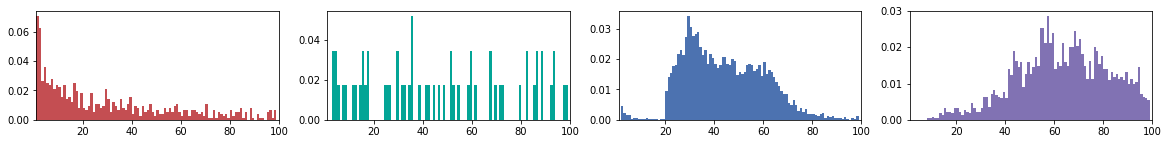

In [14]:
fig, axs = plt.subplots(ncols=4, figsize=(20,2))
for i,l in enumerate(['CAVI', 'CATH', 'Starling', 'BF']):
    ax = axs.flatten()[i]
    wlp =stats_df[stats_df.species==l].recording_duration_syllable.values[0]
    np.sum(np.array(wlp) == 1)/len(wlp)
    ax.hist(wlp,bins=np.arange(100), density=True, color = BCOL_DICT[l])
    ax.set_xlim([1,100])

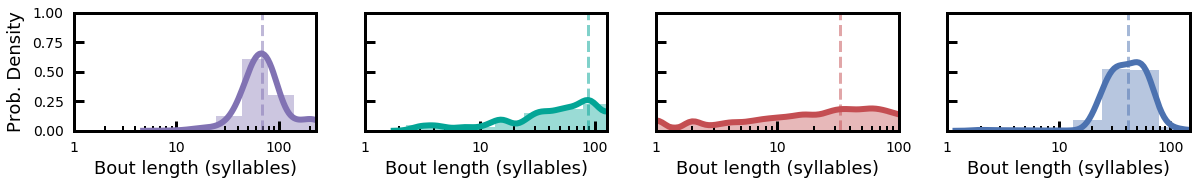

In [16]:
bw = 0.25
kwk = {"lw": 6, 'bw':bw}
d = 100
yoff=-.20
nrows = np.ceil(len(subset_MI_DF)/ncols).astype(int)
fig = plt.figure(figsize=(len(subset_MI_DF)*5,zoom/2.3)) 
gs = gridspec.GridSpec(ncols=len(subset_MI_DF), nrows=1) 
bins = np.arange(-.5, 15, .85)
for li, (species,) in enumerate([['BF'],['CATH'], ['CAVI'], ['Starling']]):
    ax = plt.subplot(gs[li])
    wl = np.log2(np.array(stats_df[stats_df.species==species].recording_duration_syllable.values[0]))
    sns.distplot((wl[wl<150]), color = BCOL_DICT[species], ax =ax, bins=bins,
                 kde_kws=kwk);  
    ax.axvline(np.median(wl), lw=3,alpha=0.5, color=BCOL_DICT[species], ls='dashed')
    ax.set_xlabel('Bout length (syllables)', labelpad=5, fontsize=18)
    
    ax.tick_params(axis='both', labelsize=14, pad=15)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
        ax.spines[axis].set_color('k')
    ax.grid(False)
    ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
    ax.tick_params(which='major', length=10, width =3)
    ax.tick_params(which='minor', length=5, width =2)
    
    #ax.set_xscale( "log" , basex=10)

    if li==0:  
        ax.set_ylabel('Prob. Density', labelpad=5, fontsize=18)
        ax.yaxis.set_label_coords(yoff,0.5)
    else:
        ax.set_yticklabels([])
    ax.set_xticks([np.log2(1),np.log2(10),np.log2(100)])
    ax.set_xticklabels(['1','10','100'])
    ax.set_xlim([np.log2(1),np.log2(song_d[species])])
    ax.set_ylim([0,1])
    minor_ticks = np.log2(np.array(list(np.arange(1,10)) + list(np.arange(10,100,10)) + list(np.arange(100,1000,100))))
    minor_locator = FixedLocator(minor_ticks)
    ax.xaxis.set_minor_locator(minor_locator)

save_fig(FIGURE_DIR/'bird_len_dist')